# HyperParameter Tuning : Experiments and Reports
## Advanced Machine Learning
### T Sanjev Vishnu

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import numpy as np
import os
import pydicom
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image, ImageDraw
import random
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dropout, Reshape, Conv2DTranspose, concatenate, Input, BatchNormalization
from tensorflow.keras import models, layers
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [2]:
def pad_up_to(t, max_in_dims, constant_values):
    s = tf.shape(t)
    paddings = [[0, m-s[i]] for (i,m) in enumerate(max_in_dims)]
    return tf.pad(t, paddings, 'CONSTANT', constant_values=constant_values)

In [3]:
path = "TrainingSet/"
y = []
for i in range(1,17):
    dynamic_path = path + "P" + str(i).zfill(2) + "list.txt"
    #print(dynamic_path)
    f = open(dynamic_path)
    data = f.read()
    data = data.split("\n")
    for i in data:
        if len(i) > 1:
            y.append(i[-28:])

In [4]:
images = [line[:8] for line in y]

In [5]:
img_ext = ".dcm"
i = 0
x_train = []
for i in range(len(images)):
    if i%2 == 0:
        ds_img = pydicom.dcmread("TrainingSet/"+images[i]+img_ext)
        numpy_array = ds_img.pixel_array
        #cv.imwrite(images[i]+".jpg",numpy_array)
        x_train.append(numpy_array)
        #plt.figure(frameon=False)
        #plt.title("Patient ID "+images[i])
        #plt.axis("off")
        plt.imsave(images[i]+".png",ds_img.pixel_array)
        #plt.imshow(ds_img.pixel_array)

In [6]:
y_train = []
for h in range(243):
    cont_f = open("TrainingSet/"+y[(h*2)])
    cont_f = cont_f.read()
    coordinates = cont_f.split("\n")
    c = []
    for i in range(len(coordinates) - 1):
        cc = coordinates[i].split()
        x1, y1 = float(cc[0]), float(cc[1])
        ccc = (x1, y1)
        c.append(ccc)
    ocont_f = open("TrainingSet/"+y[(h*2)+1])
    ocont_f = ocont_f.read()
    ocoordinates = ocont_f.split("\n")
    o = []
    for i in range(len(ocoordinates) - 1):
        oo = ocoordinates[i].split()
        x1, y1 = float(oo[0]), float(oo[1])
        ooo = (x1, y1)
        o.append(ooo)
    #print(images[2*h])
    w, height = x_train[h].shape
    oim = Image.new("L",size=(height, w))
    odraw = ImageDraw.Draw(oim)
    iim = Image.new("L",size=(height, w))
    idraw = ImageDraw.Draw(iim)
    idraw.polygon(c, fill="white")
    odraw.polygon(o, fill="white")
    oim.save("OuterContour/"+images[h*2]+"o"+".png","PNG")
    iim.save("InnerContour/"+images[h*2]+"i"+".png","PNG")
    yy = cv.imread("InnerContour/"+images[h*2]+"i"+".png",0)
    #print(yy.shape)
    y_train.append(yy)
    if h%10 == 2:
        print("*", end="")

*************************

In [7]:
X, Y  = [], []
for i in range(len(x_train)):
    #if x_train[i].shape == (256,216):
    wid, hei = x_train[i].shape
    temp = tf.convert_to_tensor((x_train[i].reshape(1,wid,hei,1))/255.000, dtype=tf.float32)
    X.append(pad_up_to(temp, [1,256,256,1], 0))
    wid, hei = y_train[i].shape
    temp = tf.convert_to_tensor((y_train[i].reshape(1,wid,hei,1))/255.000, dtype=tf.float32)
    Y.append(pad_up_to(temp, [1,256,256,1], 0))
    #print(x_train[i].shape, y_train[i].shape)

In [8]:
#print(type(Y))
def split_dataset(split):
    if split <= 1 and split > 0:
        split_point = int(len(X) - split*len(X))
        train_split_X = X[:split_point]
        train_split_Y = Y[:split_point]
        test_split_X = X[split_point:]
        test_split_Y = Y[split_point:]
        tr_lsdx = tf.data.Dataset.from_tensor_slices(train_split_X)
        tr_lsdy = tf.data.Dataset.from_tensor_slices(train_split_Y)
        tr_lsdd = tf.data.Dataset.zip((tr_lsdx, tr_lsdy))
        ts_lsdx = tf.data.Dataset.from_tensor_slices(test_split_X)
        ts_lsdy = tf.data.Dataset.from_tensor_slices(test_split_Y)
        ts_lsdd = tf.data.Dataset.zip((ts_lsdx, ts_lsdy))
        return tr_lsdd, ts_lsdd
    else :
        return("Split cannot be negative")


In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [10]:
def conv2d_block(input_tensor,l1, l2, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [11]:
def get_unet(input_img,l1, l2, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img,l1, l2, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1,l1, l2, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2,l1, l2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3,l1, l2, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4,l1, l2, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6,l1, l2, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7,l1, l2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8,l1, l2, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9,l1, l2, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model1 = models.Model(inputs=[input_img], outputs=[outputs])
    return model1

In [12]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [15]:
from focal_loss import BinaryFocalLoss

In [487]:
def loss(y_true, y_pred):
    return (BinaryFocalLoss)





In [14]:
def dice_metric_plot(m,titl):
    plt.figure(figsize = (8,8))
    plt.title(titl)
    loss_normal = max(np.max(m.history["loss"]), np.max(m.history["val_loss"]))
    plt.plot(m.history["loss"]/loss_normal, label="loss")
    plt.plot(m.history["val_loss"]/loss_normal, label="val_loss")
    plt.plot(m.history["dice_coefficient"], label="dice_coefficient")
    plt.plot(m.history["val_dice_coefficient"], label="val_dice_coefficient")
    plt.plot( np.argmax(m.history["val_dice_coefficient"]), np.max(m.history["val_dice_coefficient"]), marker=6, color="b", label="Maxima")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Metrics")
    plt.legend();
    plt.savefig(str(m)+".png")

In [ ]:
for image, mask in lsdd.take(100):
    pred_mask = dicelossmodel.predict(image)
    #print(tf.shape(pred_mask))
    sample_image, sample_mask, sample_pred_mask = tf.reshape(image, [ 256, 256, 1]), tf.reshape(mask, [ 256, 256, 1]), tf.reshape(pred_mask, [ 256, 256, 1])
    display([sample_image, sample_mask, sample_pred_mask])

In [16]:
def experiment1(split_percent, batch_size, epochs, lamb1, lamb2):
    im_width = 256
    im_height = 256
    input_img = Input((im_height, im_width, 1), name='img')
    focallossmodel = get_unet(input_img,lamb1, lamb2, n_filters=16, dropout=0.05, batchnorm=True)
    focallossmodel.compile(optimizer=Adam(), loss = BinaryFocalLoss(gamma=2) , metrics=[dice_coefficient])
    tra, tes = split_dataset(split_percent)
    focalresults = focallossmodel.fit(tra, batch_size = batch_size, epochs = epochs, validation_data = tes)
    dice_metric_plot(focalresults, "Focal Loss - Data Split : "+str(split_percent*100)+"% , Batch Size = "+ str(batch_size) + " Lambda 1 = "+str(lamb1)+" Lambda 2 = "+str(lamb2))

Epoch 1/15
145/145 [==============================] - 47s 323ms/step - loss: 0.0349 - dice_coefficient: 0.1326 - val_loss: 0.0414 - val_dice_coefficient: 0.1073
Epoch 2/15
145/145 [==============================] - 46s 320ms/step - loss: 0.0229 - dice_coefficient: 0.1885 - val_loss: 0.0343 - val_dice_coefficient: 0.2496
Epoch 3/15
145/145 [==============================] - 48s 334ms/step - loss: 0.0200 - dice_coefficient: 0.2210 - val_loss: 0.0199 - val_dice_coefficient: 0.2352
Epoch 4/15
145/145 [==============================] - 43s 297ms/step - loss: 0.0148 - dice_coefficient: 0.2672 - val_loss: 0.0152 - val_dice_coefficient: 0.2844
Epoch 5/15
145/145 [==============================] - 46s 318ms/step - loss: 0.0123 - dice_coefficient: 0.3001 - val_loss: 0.0174 - val_dice_coefficient: 0.3198
Epoch 6/15
145/145 [==============================] - 44s 306ms/step - loss: 0.0105 - dice_coefficient: 0.3282 - val_loss: 0.0418 - val_dice_coefficient: 0.2751
Epoch 7/15
145/145 [==============

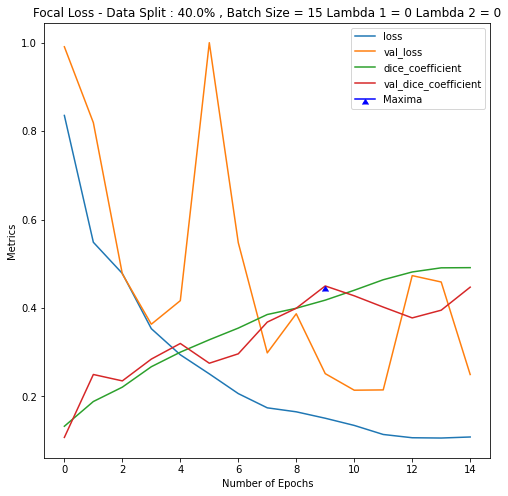

In [17]:
experiment1(0.4, 15, 15, 0, 0)

Epoch 1/15
97/97 [==============================] - 34s 346ms/step - loss: 0.0621 - dice_coefficient: 0.1015 - val_loss: 0.1321 - val_dice_coefficient: 0.1155
Epoch 2/15
97/97 [==============================] - 34s 350ms/step - loss: 0.0264 - dice_coefficient: 0.1514 - val_loss: 0.0425 - val_dice_coefficient: 0.1312
Epoch 3/15
97/97 [==============================] - 34s 351ms/step - loss: 0.0201 - dice_coefficient: 0.1859 - val_loss: 0.0447 - val_dice_coefficient: 0.1880
Epoch 4/15
97/97 [==============================] - 34s 348ms/step - loss: 0.0151 - dice_coefficient: 0.2237 - val_loss: 0.0350 - val_dice_coefficient: 0.2012
Epoch 5/15
97/97 [==============================] - 37s 380ms/step - loss: 0.0129 - dice_coefficient: 0.2524 - val_loss: 0.0238 - val_dice_coefficient: 0.2071
Epoch 6/15
97/97 [==============================] - 41s 419ms/step - loss: 0.0108 - dice_coefficient: 0.2716 - val_loss: 0.0285 - val_dice_coefficient: 0.2602
Epoch 7/15
97/97 [============================

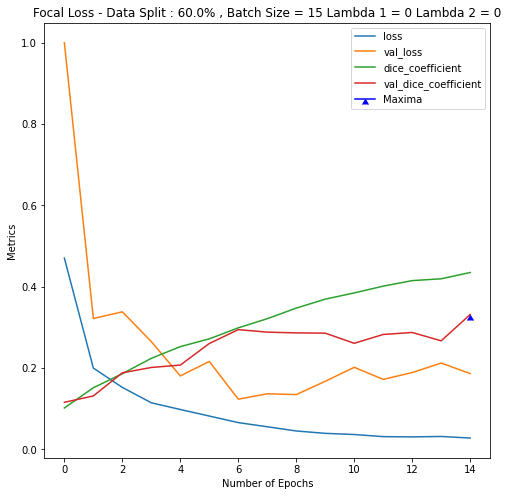

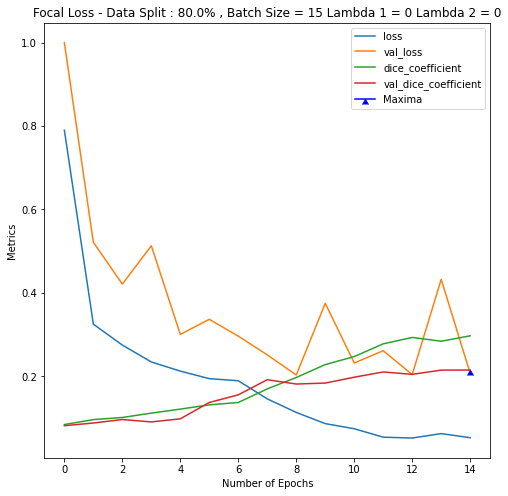

In [18]:
experiment1(0.6, 15, 15, 0, 0)
experiment1(0.8, 15, 15, 0, 0)

Epoch 1/15
194/194 [==============================] - 55s 283ms/step - loss: 0.0378 - dice_coefficient: 0.1343 - val_loss: 0.0372 - val_dice_coefficient: 0.1130
Epoch 2/15
194/194 [==============================] - 53s 274ms/step - loss: 0.0230 - dice_coefficient: 0.1856 - val_loss: 0.0511 - val_dice_coefficient: 0.1010
Epoch 3/15
194/194 [==============================] - 54s 277ms/step - loss: 0.0177 - dice_coefficient: 0.2339 - val_loss: 0.0439 - val_dice_coefficient: 0.1184
Epoch 4/15
194/194 [==============================] - 54s 278ms/step - loss: 0.0135 - dice_coefficient: 0.2765 - val_loss: 0.0188 - val_dice_coefficient: 0.2070
Epoch 5/15
194/194 [==============================] - 57s 293ms/step - loss: 0.0113 - dice_coefficient: 0.3081 - val_loss: 0.0148 - val_dice_coefficient: 0.2486
Epoch 6/15
194/194 [==============================] - 55s 284ms/step - loss: 0.0090 - dice_coefficient: 0.3452 - val_loss: 0.0172 - val_dice_coefficient: 0.2536
Epoch 7/15
194/194 [==============

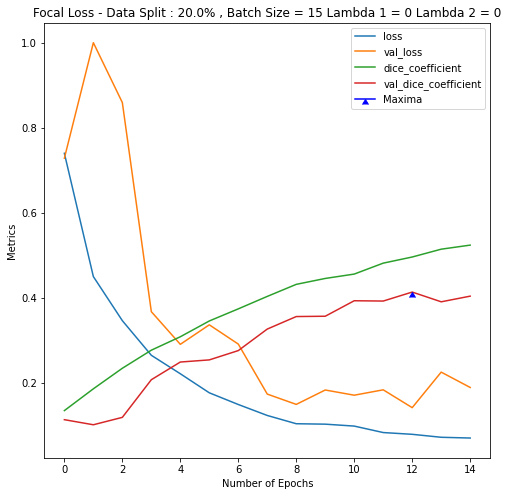

In [19]:
experiment1(0.2, 15, 15, 0, 0)

Epoch 1/5
170/170 [==============================] - 63s 369ms/step - loss: 3.0762 - dice_coefficient: 0.1091 - val_loss: 0.3656 - val_dice_coefficient: 0.0809
Epoch 2/5
170/170 [==============================] - 61s 357ms/step - loss: 0.2187 - dice_coefficient: 0.1309 - val_loss: 0.1419 - val_dice_coefficient: 0.1123
Epoch 3/5
170/170 [==============================] - 55s 322ms/step - loss: 0.1175 - dice_coefficient: 0.1418 - val_loss: 0.1319 - val_dice_coefficient: 0.0607
Epoch 4/5
170/170 [==============================] - 53s 314ms/step - loss: 0.0808 - dice_coefficient: 0.1528 - val_loss: 0.0641 - val_dice_coefficient: 0.1221
Epoch 5/5
170/170 [==============================] - 54s 317ms/step - loss: 0.0608 - dice_coefficient: 0.1483 - val_loss: 0.0639 - val_dice_coefficient: 0.0939
Epoch 1/5
170/170 [==============================] - 55s 321ms/step - loss: 0.4071 - dice_coefficient: 0.1091 - val_loss: 0.1384 - val_dice_coefficient: 0.0793
Epoch 2/5
170/170 [=====================

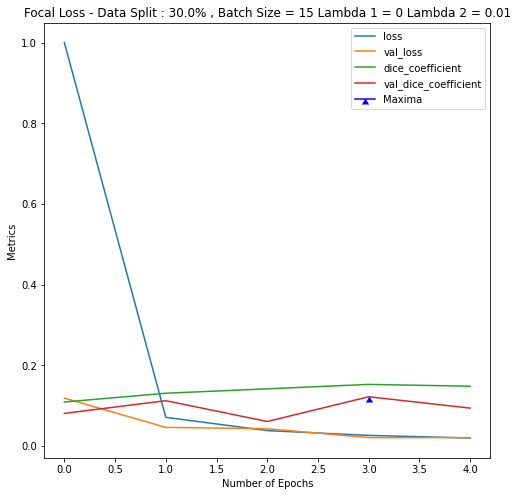

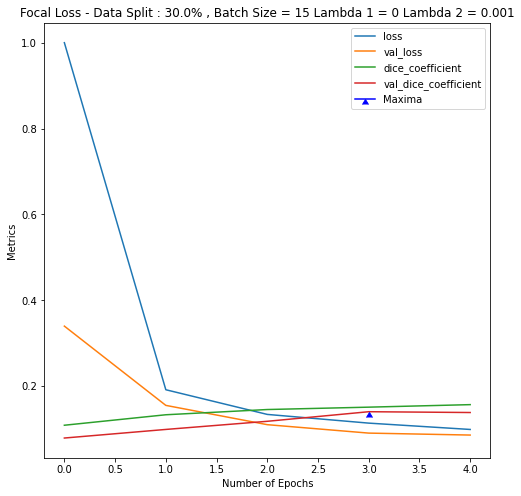

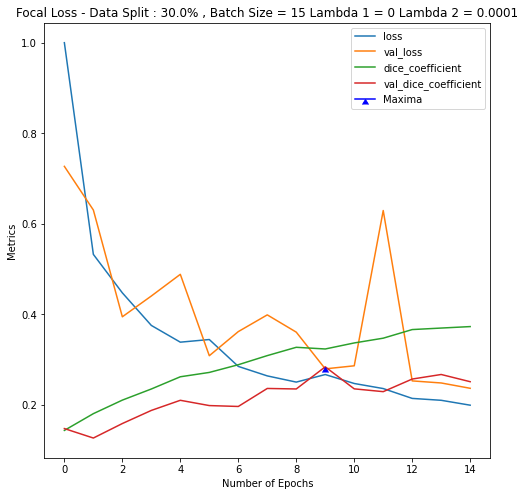

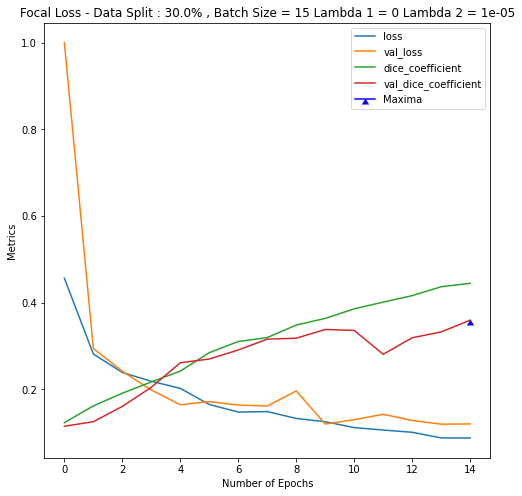

In [22]:
experiment1(0.3, 15, 5, 0, 0.01)
experiment1(0.3, 15, 5, 0, 0.001)
experiment1(0.3, 15, 15, 0, 0.0001)
experiment1(0.3, 15, 15, 0, 0.00001)

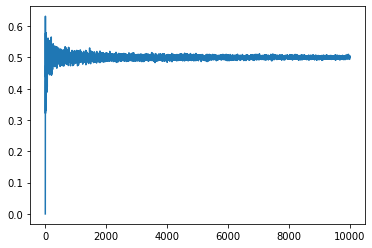

In [96]:
y3 = []
for j in range(1,10000):
    s = 0

    for i in range(1,j):
        n = random.uniform(0,1)
        s += abs(n)

    y3.append(s/j)

plt.plot(y3)

In [50]:
import math

In [92]:
y4 = []

for j in range(100):
    s = 0
    for i in range(1,1000000):
        n = random.uniform(0,1)
        s += abs(n)

    y4.append(s)

In [94]:
print(sum(y4)/100)

499990.49657579174


In [95]:
print(y4)

[500037.6918067724, 499915.19606662885, 499962.56675900164, 500173.644702803, 499717.0452331209, 500334.56512077176, 500361.3228954539, 499952.59853701206, 500133.63236802287, 500216.83437624876, 499927.60792743694, 499936.9030434895, 500325.59407767834, 500170.88491605985, 499759.67135143105, 500676.01376415876, 499837.2762028823, 500015.74939316703, 499791.60358672275, 500396.9798737398, 499888.4370899381, 499734.0938636578, 499765.510624852, 500124.9846631009, 499825.99693040067, 499972.5688673161, 499505.6311561462, 500243.2838396781, 499581.851822816, 500161.8644015346, 499983.69762605586, 500588.21190631913, 500010.6859932707, 499884.1007690655, 499757.2438662425, 500612.4393191315, 500270.4801490519, 500021.35033149377, 499854.3189564701, 500429.4503697331, 500456.8794662542, 500189.03824435535, 500066.59273959574, 500075.58966909675, 499681.2856842142, 499804.94574266614, 499451.5319388508, 499560.2348759143, 499823.21062061563, 499896.5881451793, 500008.63540851197, 499860.445